We're going to use image vectors from ResNeXt, so let's introduce some code that will get our image vectors.

In [1]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np


DEVICE = torch.device('cpu')
OUTPUT_SIZE = 2048

model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V2)

extraction_layer = model._modules.get('avgpool')
model.to(DEVICE)
model.eval()

scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vec(arg, model, extraction_layer):
    image = normalize(to_tensor(scaler(arg))).unsqueeze(0).to(DEVICE)
    result = torch.zeros(1, OUTPUT_SIZE, 1, 1)
    def copy_data(m, i, o):
        result.copy_(o.data)
    hooked = extraction_layer.register_forward_hook(copy_data)
    with torch.no_grad():
        model(image)
    hooked.remove()
    return result

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-1a0047aa.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-1a0047aa.pth
100%|██████████| 95.8M/95.8M [00:01<00:00, 79.0MB/s]


Let's get our image vectors and thumbnails. We're resource constrained, so we're going to just take a sample of our data.

In [2]:
import arrow
import base64
import pandas as pd
from glob import iglob
from io import BytesIO
from os.path import basename
from PIL import Image

STOP = 500
THUMBNAIL_SIZE = (64, 64)
TRAIN = '/kaggle/input/parkinson-yolo-dataset/YOLODatasetFull/images/'


def embed(model, filename: str):
    with Image.open(fp=filename, mode='r') as image:
        return get_vec(arg=image.convert('RGB'), model=model, extraction_layer=extraction_layer).numpy().reshape(OUTPUT_SIZE,)


# https://stackoverflow.com/a/952952
def flatten(arg):
    return [x for xs in arg for x in xs]

def png(filename: str) -> str:
    with Image.open(fp=filename, mode='r') as image:
        buffer = BytesIO()
        # our images are pretty big; let's shrink the hover images to thumbnail size
        image.resize(size=THUMBNAIL_SIZE).convert('RGB').save(buffer, format='png')
        return 'data:image/png;base64,' + base64.b64encode(buffer.getvalue()).decode()

def label(filename: str) -> str:
    pieces = filename.split('.')
    filename = '.'.join(pieces[:-1]) + '.txt'
    pieces = filename.split('/')
    pieces = [piece if piece != 'images' else 'labels' for piece in pieces]
    filename = '/'.join(pieces)
    with open(file=filename, mode='r') as fp:
        return fp.readlines()[0].split(' ')[0]
    

def get_picture_from_glob(arg: str, stop: int) -> list:
    time_get = arrow.now()
    result = [pd.Series(data=[basename(input_file), embed(model=model, filename=input_file), png(filename=input_file), label(filename=input_file)], 
                        index=['name', 'value', 'png', 'label'])
        for index, input_file in enumerate(iglob(pathname=arg)) if index < stop and input_file.endswith('.png')]
    print('encoded {} rows in {}'.format(len(result), arrow.now() - time_get))
    return result

time_start = arrow.now()
train_dict = {basename(folder) : folder + '/*.*' for folder in iglob(TRAIN + '/*')}
train_df = pd.DataFrame(data=flatten(arg=[get_picture_from_glob(arg=value, stop=STOP) for key, value in train_dict.items()]))
print('done in {}'.format(arrow.now() - time_start))

encoded 333 rows in 0:00:52.865533
encoded 500 rows in 0:01:20.806202
done in 0:02:13.741488


Are our classes balanced?

In [3]:
train_df['label'].value_counts().to_frame().sort_index().T

label    0    1    2    3
count  156  240  220  217

Our classes are not balanced; we may want to fix that.

Next let's use TSNE to get x/y coordinates so we can make an exploratory visual.

In [4]:
import arrow
from sklearn.manifold import TSNE

time_start = arrow.now()
reducer = TSNE(random_state=2025, verbose=True, n_jobs=1, perplexity=20.0, init='random')
train_df[['x', 'y']] = reducer.fit_transform(X=train_df['value'].apply(func=pd.Series))
print('done with TSNE in {}'.format(arrow.now() - time_start))

[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 833 samples in 0.016s...
[t-SNE] Computed neighbors for 833 samples in 0.137s...
[t-SNE] Computed conditional probabilities for sample 833 / 833
[t-SNE] Mean sigma: 3.401061
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.574623
[t-SNE] KL divergence after 1000 iterations: 0.418693
done with TSNE in 0:00:03.120843


Now we're ready to plot.

In [5]:
from bokeh.models import ColumnDataSource
from bokeh.models import HoverTool

from bokeh.plotting import figure
from bokeh.plotting import output_notebook
from bokeh.plotting import show
from bokeh.palettes import Turbo256
from bokeh.transform import factor_cmap

output_notebook()

datasource = ColumnDataSource(train_df[['png', 'label', 'x', 'y']])
factor_count = max(train_df['label'].nunique(), 3)
indices = np.linspace(0, len(Turbo256)-1, factor_count, dtype=int)
palette = [Turbo256[index] for index in indices]
mapper = factor_cmap(field_name = 'label', palette=palette, factors=train_df['label'].unique().tolist(), start=0, end=factor_count-1, )

plot_figure = figure(title='TSNE projection: Parkinson', width=1000, height=800, tools=('pan, wheel_zoom, reset'))

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@png' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 18px'>@label</span>
    </div>
</div>
"""))

plot_figure.scatter(x='x', y='y', source=datasource, line_alpha=0.6, fill_alpha=0.6, size=7, color=mapper)
show(plot_figure)

Loading BokehJS ...

What do we see? We see a lot of clustering, but honestly it looks like we have more classes than we should by a factor of two. Let's build a model and see how it does.

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df['value'].apply(pd.Series), train_df['label'], test_size=0.2, random_state=2024, stratify=train_df['label'])
logreg = LogisticRegression(max_iter=1000, tol=1e-12).fit(X_train, y_train)
print('model fit in {} iterations'.format(logreg.n_iter_[0]))
print('accuracy: {:5.4f}'.format(accuracy_score(y_true=y_test, y_pred=logreg.predict(X=X_test))))
print('f1: {:5.4f}'.format(f1_score(average='weighted', y_true=y_test, y_pred=logreg.predict(X=X_test))))
print(classification_report(y_true=y_test, y_pred=logreg.predict(X=X_test)))

model fit in 862 iterations
accuracy: 0.8443
f1: 0.8445
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        31
           1       0.88      0.90      0.89        48
           2       0.84      0.82      0.83        44
           3       0.88      0.86      0.87        44

    accuracy                           0.84       167
   macro avg       0.84      0.84      0.84       167
weighted avg       0.84      0.84      0.84       167



That's not bad for not much effort. Where are our errors?

<Axes: xlabel='x', ylabel='y'>

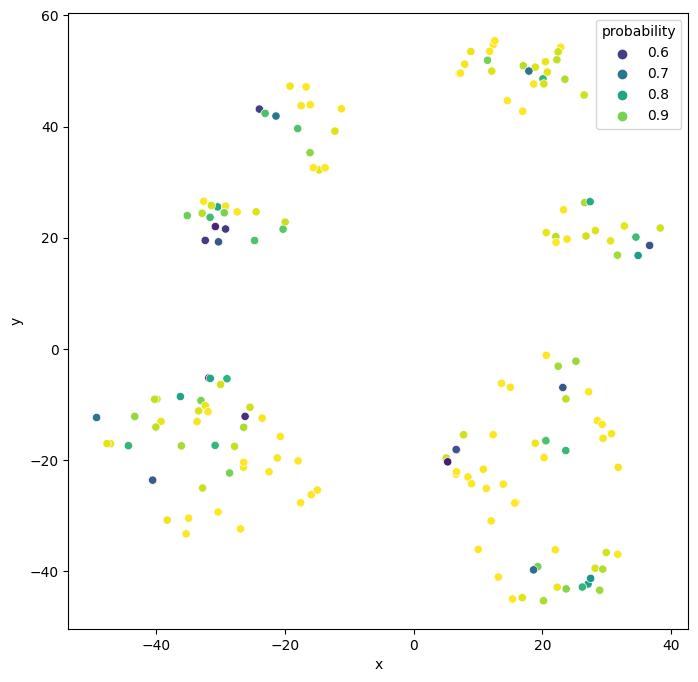

In [7]:
import matplotlib.pyplot as plt
from seaborn import scatterplot

fig, ax = plt.subplots(figsize=(8, 8))
plot_df = train_df.loc[X_test.index][['x', 'y']].copy()
plot_df['probability'] = np.max(logreg.predict_proba(X=X_test), axis=1)
scatterplot(ax=ax, data=plot_df, x='x', y='y', hue='probability', palette='viridis')

Our model has relatively high model probabilities even when it's wrong.